In [1]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
import pymc3

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
TITLE_FONT_SIZE = 14
AXIS_FONT_SIZE = 12

In [3]:
W = np.array([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0]
])

D = np.diag(np.sum(W, axis=0))

In [4]:
def alr(theta):
    return np.log(theta[:-1] / theta[-1])

def inv_alr(x):
    theta = np.concatenate([np.exp(x), np.array([1.0])])
    return theta / np.sum(theta)

In [5]:
def sample_cov(x, y):
    n = x.size
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / (n - 1)  

## $\tilde w_i \sim N(0, (D - \rho W)^{-1}_{ii} \Sigma)$

In [6]:
def simulate_one_marginal(A, Sigma, i, nsamples):
    dim = Sigma.shape[0]
    draws = np.random.multivariate_normal(mean=np.zeros(dim), cov=A[i, i] * Sigma, size=nsamples)
    return np.apply_along_axis(inv_alr, 1, draws)

In [7]:
def simulate_indep(Sigma, nsamples):
    dim = Sigma.shape[0]
    draws = np.random.multivariate_normal(mean=np.zeros(dim), cov=Sigma, size=nsamples)
    return np.apply_along_axis(inv_alr, 1, draws)

In [8]:
rho = 0.9
A = np.linalg.inv(D - rho * W)

In [9]:
corr = -0.9
var = 1
Sigma = np.array([[var, corr], [corr, var]])
draws = simulate_one_marginal(A, Sigma, 1, 10000)

In [10]:
i = 1
var = 1
covs01 = []
covs02 = []
covs12 = []
corrs = np.linspace(-0.99, 0.99, 50)

for corr in corrs:
    Sigma = np.array([[var, corr], [corr, var]])
    #draws = simulate_one_marginal(A, Sigma, i, 10000)
    draws = simulate_indep(Sigma, 10000)
    covs01.append(sample_cov(draws[:, 0], draws[:, 1]))
    covs02.append(sample_cov(draws[:, 0], draws[:, 2]))
    covs12.append(sample_cov(draws[:, 1], draws[:, 2]))

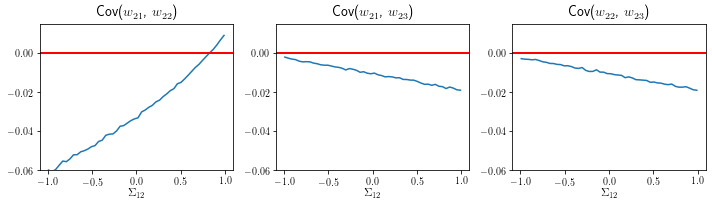

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].plot(corrs, covs01)
axes[0].set_title(r"Cov($w_{{{%i}}1}$, $w_{{{%i}}2}$)" % (i, i), fontsize=TITLE_FONT_SIZE)
axes[0].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)

axes[1].plot(corrs, covs02)
axes[1].set_title(r"Cov($w_{{{%i}}1}$, $w_{{{%i}}3}$)" % (i, i), fontsize=TITLE_FONT_SIZE)
axes[1].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)

axes[2].plot(corrs, covs12)
axes[2].set_title(r"Cov($w_{{{%i}}2}$, $w_{{{%i}}3}$)" % (i, i), fontsize=TITLE_FONT_SIZE)
axes[2].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)

for i in range(3):
    axes[i].axhline(0, color="red", lw=2)
    axes[i].set_ylim((-0.06, 0.015))
plt.tight_layout()
plt.savefig("../images/cov_w1.pdf")
plt.show()

## $(\tilde w_i, w \theta_j)  \sim N(0, (D - \rho W)^{-1}_{(i,j) \times (i, j)}  \otimes \Sigma)$

In [19]:
# This function simulates from the joint marginal distribution
# of (theta_{i}, theta_{j})

def simulate_joint_marginal(A, Sigma, i, j, nsamples):
    dim = Sigma.shape[0]
    cov = np.kron(A[[[i],[j]],[i, j]], Sigma)
    draws = np.random.multivariate_normal(mean=np.zeros(2 * dim), cov=cov, size=nsamples)
    theta_i = np.apply_along_axis(inv_alr, 1, draws[:, :dim])
    theta_j = np.apply_along_axis(inv_alr, 1, draws[:, dim:])
    return theta_i, theta_j

In [20]:
i = 0
j = 2

corrs = np.linspace(-0.99, 0.99, 50)
covs = defaultdict(list)
for corr in corrs:
    Sigma = np.array([[var, corr], [corr, var]])
    ws = simulate_joint_marginal(A, Sigma, i, j, 10000)
    for l in range(3):
        for m in range(3):
            covs[(l, m)].append(sample_cov(ws[0][:, l], ws[1][:, m]))

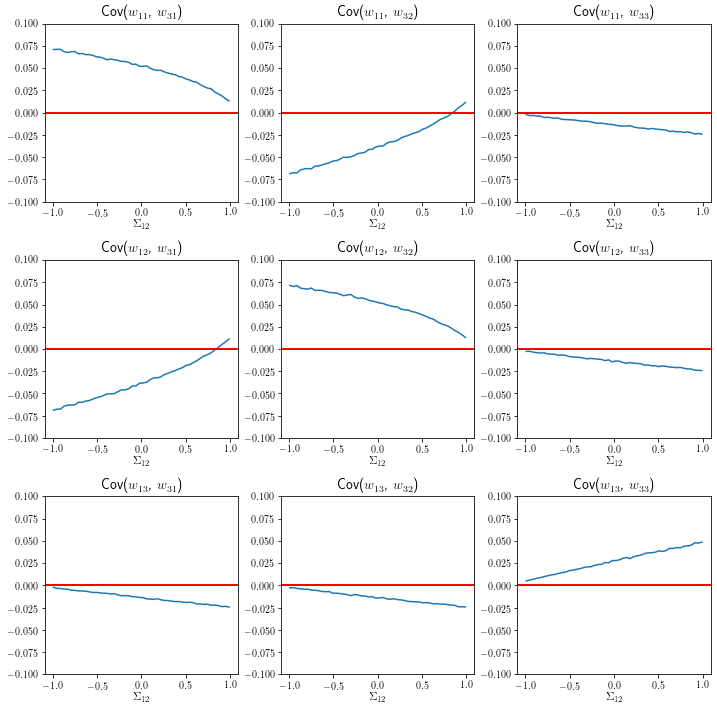

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for l in range(3):
    for m in range(3):
        axes[l][m].plot(corrs, covs[(l, m)])
        axes[l][m].set_title(r"Cov($w_{{{%i}} {{%i}}}$, $w_{{{%i}} {{%i}}}$)" % (i+1, l+1, j+1, m+1),
                          fontsize=TITLE_FONT_SIZE)
        axes[l][m].set_xlabel(r"$\Sigma_{12}$", fontsize=AXIS_FONT_SIZE)
        axes[l][m].set_ylim(-0.1, 0.1)
        axes[l][m].axhline(0, color="red", lw=2)

plt.tight_layout()
plt.savefig("../images/cov_w1_w3.pdf")
plt.show()

## Simulation against independent Dirichlet

In [30]:
from scipy.stats import dirichlet
import matplotlib.lines
import matplotlib.tri as tri

In [31]:
Nsamples = 20
samplesDir1 = dirichlet.rvs([1, 1, 1], Nsamples)
samplesDir2 = dirichlet.rvs([1, 1, 1], Nsamples)

In [32]:
corr = 0.5
Sigma = np.array([[var, corr], [corr, var]])
samplesLogit1, samplesLogit2 = simulate_joint_marginal(A, Sigma, 0, 1, Nsamples)

In [33]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

In [34]:
SQRT3 = np.sqrt(3)
SQRT3OVER2 = SQRT3 / 2.

def unzip(l):
    return zip(*l)

def permute_point(p, permutation=None):
    if not permutation:
        return p
    return [p[int(permutation[i])] for i in range(len(p))]

def project_point(p, permutation=None):
    permuted = permute_point(p, permutation=permutation)
    a = permuted[0]
    b = permuted[1]
    x = a + b/2.
    y = SQRT3OVER2 * b
    return np.array([x, y])

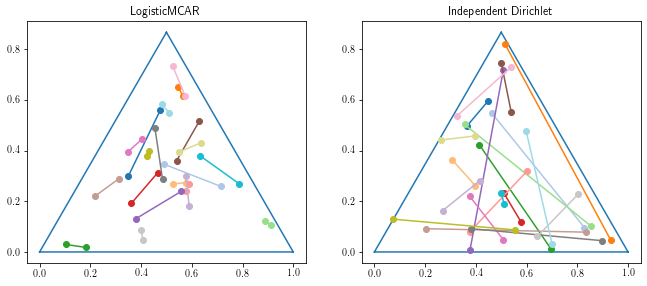

In [35]:
cmap = matplotlib.cm.get_cmap("tab20")

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

axes[0].triplot(triangle)
axes[1].triplot(triangle)

for i in range(Nsamples):
    proj1 = project_point(samplesLogit1[i, :])
    proj2 = project_point(samplesLogit2[i, :])
    
    axes[0].plot([proj1[0]], [proj1[1]], marker="o", color=cmap.colors[i], figure=fig)
    axes[0].plot([proj2[0]], [proj2[1]], marker="o", color=cmap.colors[i], figure=fig)
    axes[0].plot([proj1[0], proj2[0]], [proj1[1], proj2[1]], "-", color=cmap.colors[i])
    
axes[0].set_title("LogisticMCAR")
axes[0].set_aspect("equal")
    
for i in range(Nsamples):
    proj1 = project_point(samplesDir1[i, :])
    proj2 = project_point(samplesDir2[i, :])
    
    axes[1].plot([proj1[0]], [proj1[1]], marker="o", color=cmap.colors[i], figure=fig)
    axes[1].plot([proj2[0]], [proj2[1]], marker="o", color=cmap.colors[i], figure=fig)
    axes[1].plot([proj1[0], proj2[0]], [proj1[1], proj2[1]], "-", color=cmap.colors[i])
    
axes[1].set_title("Independent Dirichlet")
axes[1].set_aspect("equal")

plt.savefig("../images/triplot.pdf")
plt.show()

## Histogram of distancies

In [36]:
Nsamples = 10000
samplesDir1 = dirichlet.rvs([1, 1, 1], Nsamples)
samplesDir2 = dirichlet.rvs([1, 1, 1], Nsamples)

distDir = np.sqrt(np.sum((samplesDir1 - samplesDir2) ** 2, axis=1))

In [37]:
corr = 0.5
Sigma = np.array([[var, corr], [corr, var]])
distLogits = []

samplesLogit1, samplesLogit2 = simulate_joint_marginal(A, Sigma, 0, 1, Nsamples)
distLogits.append(np.sqrt(np.sum((samplesLogit1 - samplesLogit2) ** 2, axis=1)))

samplesLogit1, samplesLogit2 = simulate_joint_marginal(A, Sigma, 0, 4, Nsamples)
distLogits.append(np.sqrt(np.sum((samplesLogit1 - samplesLogit2) ** 2, axis=1)))

In [38]:
np.where(distLogits == max(distLogits[1]))

(array([1]), array([7414]))

In [39]:
xlim = max(max(list(map(max, distLogits))), max(distDir))

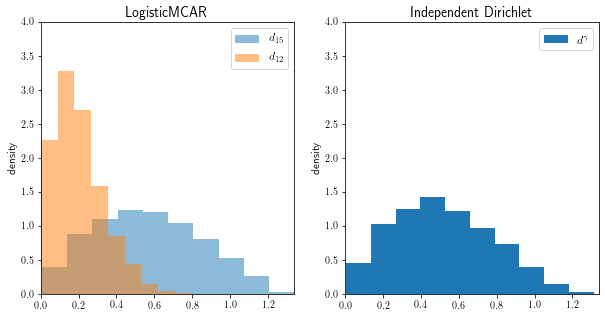

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].hist(distLogits[1], alpha=0.5, label=r"$d_{15}$", density=True)
axes[0].hist(distLogits[0], alpha=0.5, label=r"$d_{12}$", density=True)
axes[0].set_title("LogisticMCAR", fontsize=TITLE_FONT_SIZE)

axes[1].hist(distDir, density=True, label=r"$d^\gamma$")
axes[1].set_title("Independent Dirichlet", fontsize=TITLE_FONT_SIZE)
for i in range(2):
    axes[i].set_xlim((0, xlim))
    axes[i].set_ylim(0, 4)
    axes[i].set_ylabel("density", fontsize=TITLE_FONT_SIZE-3)
    

axes[0].legend(loc="upper right", fontsize=TITLE_FONT_SIZE-2)
axes[1].legend(loc="upper right", fontsize=TITLE_FONT_SIZE-2)
plt.savefig("../images/distances_hist.pdf")
plt.show()